Importing the dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

#Data Preprocessing

In [ ]:
# Step 1: Load the data
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']
url_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

data = pd.read_csv(url_data, names=columns, skipinitialspace=True)
test = pd.read_csv(url_test, names=columns, skipinitialspace=True, skiprows=1)
data = pd.concat([data, test], ignore_index=True)
data['income'] = data['income'].str.replace('.', '', regex=False)
data['income'] = (data['income'] == '>50K').astype(int)

print("Initial data shape:", data.shape)

Initial data shape: (48842, 15)


In [ ]:
# Count '?' in each column
for col in data.columns:
    missing_count = (data[col] == '?').sum()
    if missing_count > 0:
        print(f"Column {col} has {missing_count} missing values ('?')")

Column workclass has 2799 missing values ('?')
Column occupation has 2809 missing values ('?')
Column native-country has 857 missing values ('?')


Since workclass, occupation, and native-country are categorical, imputing with a placeholder like 'missing' creates an artificial category that might confuse the model if 'missing' doesn’t have a meaningful interpretation. Dropping rows avoids this.

The dataset has 48,842 rows. From the previous code, we saw:

workclass: 2,799 missing (?)

occupation: 2,809 missing

native-country: 857 missing

Total rows with at least one ? : Approximately 5,000 (some rows have ? in multiple columns). Dropping ~5,000 rows leaves ~43,842 rows, which is still plenty for training a RandomForestClassifier.

I am dropping the rows because it removes any kind of assumptions from the model, while it might lead to a little bit of bias, the dataset is still large enough to not worry about that.

In [ ]:
# Step 2: Drop rows with '?'
rows_with_missing = data[['workclass', 'occupation', 'native-country']].eq('?').any(axis=1)
print(f"Rows with at least one '?': {rows_with_missing.sum()}")
data = data[~rows_with_missing]
print("Data shape after dropping rows with '?':", data.shape)

Rows with at least one '?': 3620
Data shape after dropping rows with '?': (45222, 15)


In [ ]:
# Step 3: Separate features and target
X = data.drop('income', axis=1)
y = data['income']
print("\nX shape:", X.shape)
print("y shape:", y.shape)


X shape: (45222, 14)
y shape: (45222,)


In [ ]:
# Step 4: One-hot encode categorical features
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship',
                    'race', 'sex', 'native-country']
print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)
X_encoded = pd.get_dummies(X, columns=categorical_cols, dtype=int)
print("\nX_encoded shape:", X_encoded.shape)
print("First few columns of X_encoded:\n", X_encoded.columns[:10])


Numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

X_encoded shape: (45222, 104)
First few columns of X_encoded:
 Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc'],
      dtype='object')


#Data Standardization

In [ ]:
# Step 5: Scale numerical features
scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])
print("\nScaled numerical columns:\n", X_encoded[numerical_cols].head())


Scaled numerical columns:
         age    fnlwgt  education-num  capital-gain  capital-loss  \
0  0.034201 -1.062295       1.128753      0.142888      -0.21878   
1  0.866417 -1.007438       1.128753     -0.146733      -0.21878   
2 -0.041455  0.245284      -0.438122     -0.146733      -0.21878   
3  1.093385  0.425853      -1.221559     -0.146733      -0.21878   
4 -0.798015  1.407393       1.128753     -0.146733      -0.21878   

   hours-per-week  
0       -0.078120  
1       -2.326738  
2       -0.078120  
3       -0.078120  
4       -0.078120  


#Train Test Split

In [ ]:
# Step 6: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=7)
print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (36177, 104)
X_test shape: (9045, 104)


In [ ]:
#Step 7: Randomized Search for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05],
    'max_features': ['sqrt', 'log2', 0.3],
    'max_leaf_nodes': [None, 100, 500],
    'class_weight': [None, 'balanced', {0:1, 1:3}],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
print("\nStarting Randomized Search...")
random_search.fit(X_train, y_train)
print("Randomized Search complete!")
print("\nBest Parameters:", random_search.best_params_)
print("Best AUC (CV):", random_search.best_score_)


Starting Randomized Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Randomized Search complete!

Best Parameters: {'n_estimators': 300, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': 500, 'max_features': 0.3, 'max_depth': 30, 'class_weight': 'balanced', 'bootstrap': True}
Best AUC (CV): 0.9165494973498596



Random Forest Classifier Results (Fast-Tuned, Adult Income):
Accuracy: 0.8304
Precision: 0.8548
Recall: 0.6183
AUC: 0.9169

Confusion Matrix:
[[5562 1203]
 [ 331 1949]]


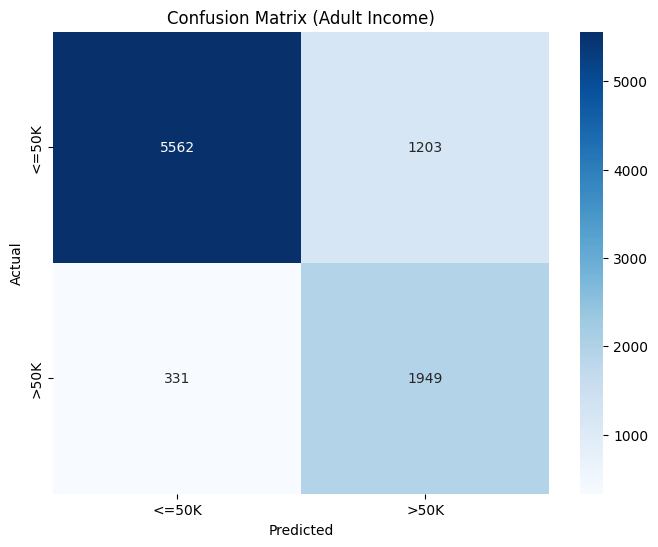

In [ ]:
# Get best model
best_rf = random_search.best_estimator_

# Predict
y_pred = best_rf.predict(X_test)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print("\nRandom Forest Classifier Results (Fast-Tuned, Adult Income):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix (Adult Income)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Step 9: Feature importance
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))


Top 10 Feature Importances:
                              feature  importance
31  marital-status_Married-civ-spouse    0.147324
0                                 age    0.109831
3                        capital-gain    0.096084
50               relationship_Husband    0.085180
2                       education-num    0.080278
5                      hours-per-week    0.054131
33       marital-status_Never-married    0.045918
1                              fnlwgt    0.032721
53             relationship_Own-child    0.029099
55                  relationship_Wife    0.023954
